## Initialization

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import matplotlib.pyplot as plt

import os
import time
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

#Models
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor


# Model evaluation und visualisation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

np.random.seed(42)

## Load and investigate data

In [ ]:
# NOTICE --- dtype={'Date': 'str'}
#data = pd.read_csv('beverage-import.csv',dtype={'Date': 'str'})

from google.colab import drive 
drive.mount("/content/gdrive")
data = pd.read_csv('/content/gdrive/MyDrive/Project/beverage-import.csv', index_col=0)

Mounted at /content/gdrive


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12,13,14,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
column_names = data.columns
for c in column_names:
    print( c, ':', data[c].nunique(), data[c].isna().sum() )

Customer : 3112 0
Sales Rep : 45 0
Month : 12 0
Year : 3 0
Date : 28 0
Code and description  : 1136 0
Code Prod : 723 0
Description : 1328 0
Quantity : 1375 0
Units : 7 5767
Total quantity : 1264 0
Value Sale : 28467 0
Tax : 22865 0
Total value sale : 26529 0
Channel : 15 48
Brand : 62 0
Category : 14 0
Comment : 14 80505
Unit price : 9339 629
Unnamed: 20 : 0 81228


## Clean the data

In [ ]:
data = data.drop(['Unnamed: 20', 'Comment'], axis=1)

In [ ]:
data['NewDate']= data['Date'] \
        .map({'ENERO -- 2015':1, 'FEBRERO -- 2015':2, 'MARZO -- 2015':3,
       'ABRIL -- 2015':4, 'MAYO -- 2015':5, 'JUNIO -- 2015':6, 'JULIO -- 2015':7,
       'AGOSTO -- 2015':8, 'SEPTIEMBRE -- 2015':9, 'OCTUBRE -- 2015':10,
       'NOVIEMBRE -- 2015':11, 'DICIEMBRE -- 2015':12, 'ENERO -- 2016':13,
       'FEBRERO -- 2016':14, 'MARZO -- 2016':15, 'ABRIL -- 2016':16,
       'MAYO -- 2016':17, 'JUNIO -- 2016':18, 'JULIO -- 2016':19, 'AGOSTO -- 2016':20,
       'SEPTIEMBRE -- 2016':21, 'OCTUBRE -- 2016':22, 'NOVIEMBRE -- 2016':23,
       'DICIEMBRE -- 2016':24, 'ENERO -- 2017':25, 'FEBRERO -- 2017':26,
       'MARZO -- 2017':27, 'ABRIL -- 2017':28})#, 'ABRIL -- 2017':28

In [ ]:
# NewDate replaces them
data=data.drop(['Month','Year','Date'],axis=1)

In [ ]:
# NewDate is now numeric
numeric_columns=['NewDate',"Quantity", "Total quantity", "Value Sale", "Tax", "Total value sale", "Unit price" ]

In [ ]:
#Removing brackets
data['Total value sale'] = data['Total value sale'].replace(to_replace='\(', value="", regex=True)
data['Total value sale'] = data['Total value sale'].replace(to_replace='\)', value="", regex=True)

In [ ]:
data = data.dropna() # Removes every row which has at least one NaN

In [ ]:
for c in numeric_columns:
    data[c].replace(',', '', regex=True, inplace=True)
    data[c]= pd.to_numeric( data[c],errors='raise') 

In [ ]:
# Some more cleaning ... (used to be in the cat_names handling)
data=data.drop(['Description', 'Code and description '],axis=1)

In [ ]:
print('Data length ',len(data),'\n' )

column_names = data.columns
for c in column_names:
    print( c, ':',type(data[c][0]),data[c].nunique() )

Data length  74832 

Customer : <class 'str'> 3034
Sales Rep : <class 'str'> 45
Code Prod : <class 'str'> 715
Quantity : <class 'numpy.float64'> 896
Units : <class 'str'> 7
Total quantity : <class 'numpy.float64'> 896
Value Sale : <class 'numpy.float64'> 24043
Tax : <class 'numpy.float64'> 18371
Total value sale : <class 'numpy.float64'> 21633
Channel : <class 'str'> 14
Brand : <class 'str'> 62
Category : <class 'str'> 13
Unit price : <class 'numpy.float64'> 6921
NewDate : <class 'numpy.int64'> 28


In [ ]:
originalData = data

## Test-Train split and DataFrame to Numpy

In [ ]:
# Change -- first 25 vs. final 3 months

# The first 25 months are the training set and the final 3 months are the test set
# Other combinations are possible, e.g., more months at the end

features_train=data[data['NewDate']<23]
features_test=data[data['NewDate']>=23]

In [ ]:
label_train=features_train['Total quantity']
label_test=features_test['Total quantity']

In [ ]:
features_train=features_train.drop('Total quantity', axis=1)
features_test=features_test.drop('Total quantity', axis=1)

In [ ]:
print(features_train.shape, label_train.shape)

(58649, 13) (58649,)


In [ ]:
print(features_train.columns)

Index(['Customer', 'Sales Rep', 'Code Prod', 'Quantity', 'Units', 'Value Sale',
       'Tax', 'Total value sale', 'Channel', 'Brand', 'Category', 'Unit price',
       'NewDate'],
      dtype='object')


In [ ]:
cat_names = ['Customer', 'Sales Rep', 'Code Prod', 'Channel',  'Brand', 'Category','Units' ] 
num_names = [ 'NewDate', 'Quantity', 'Total value sale', 'Value Sale', 'Tax','Unit price'] 

In [ ]:
features_cat = features_train[cat_names]
features_num = features_train[num_names]

In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.attribute_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [ ]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_names)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

temp = num_pipeline.fit_transform(features_num)

In [ ]:
# handle_unknown = 'ignore' to handle item IDs that appear only in the test set
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_names)),
        ('cat_encoder', OneHotEncoder(sparse=False,handle_unknown = 'ignore')),
    ])

temp1 = cat_pipeline.fit_transform(features_train)

In [ ]:
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
data_prepared = full_pipeline.fit_transform(features_train)

In [ ]:
print(data_prepared.shape, label_train.shape)

(58649, 3219) (58649,)


## Linear Regression

In [ ]:
start = time.time()

linear_regression = LinearRegression()
linear_regression.fit(data_prepared, label_train)

t=(time.time() - start)/60
print( 'Time in minutes:%5.2f'%t)

Time in minutes: 1.15


In [ ]:
predictions = linear_regression.predict(data_prepared)

mse = mean_squared_error(label_train, predictions)
rmse = np.sqrt(mse)
print('RMSE %5.4f'% rmse)

score = linear_regression.score(data_prepared, label_train)
print(' r^2 score %8.3f \n' % score)

RMSE 0.0000
 r^2 score    1.000 



In [ ]:
test_prepared = full_pipeline.transform(features_test)

test_prepared.shape

(16183, 3219)

In [ ]:
final_predictions = linear_regression.predict(test_prepared)

final_mse = mean_squared_error(label_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print('RMSE %5.4f'%final_rmse)

score = linear_regression.score(test_prepared,label_test)
print(' r^2 score %8.3f \n' % score)

RMSE 0.6508
 r^2 score    1.000 



Business insight

In [ ]:
df = pd.DataFrame( columns=['prediction','label'] )
df['prediction']=pd.Series(final_predictions)
df['label']=label_test.reset_index()['Total quantity']
df

,prediction,label
0,5.993020,6.0
1,2.000000,2.0
2,2.000000,2.0
3,1.000000,1.0
4,2.000000,2.0
...,...,...
16178,8.708265,4.0
16179,24.708265,20.0
16180,6.708265,2.0
16181,5.727682,1.0


In [ ]:
Ds=pd.DataFrame(columns=['P','L','D'] )
i=0
for index,row in df.iterrows():
    diff= round(row['prediction'],0)-row['label']
    if not diff==0:
        i+=1
        Ds=Ds.append({'P': row['prediction'],'L': row['label'],'D':diff },ignore_index=True )
print(i)

586


In [ ]:
Ds.describe()

,P,L,D
count,586.000000,586.000000,586.000000
mean,29.782332,27.084727,2.988652
std,96.848545,96.893926,2.064327
min,-37.032699,-41.000000,-1.000000
25%,5.528036,2.000000,2.000000
50%,10.021006,6.000000,3.000000
75%,23.859229,24.000000,5.000000
max,1204.708265,1200.000000,7.000000


In [ ]:
# Out of the test set (three last months, 6023 transactions)
# There were 348 predictions which were not perfect
# and you can further analyze them through the data frame Ds

## Decision Tree

In [ ]:
import time
start = time.time()

DTR= DecisionTreeRegressor()
DTR.fit(data_prepared, label_train)

t=(time.time() - start)/60
print( 'Time in minutes:%5.2f'%t)

Time in minutes: 0.39


In [ ]:
predictions = DTR.predict(data_prepared)

DTR_mse = mean_squared_error(label_train, predictions)
print('%5.4f'%DTR_mse)

DTR_rmse = np.sqrt(DTR_mse)
print('RMSE %5.4f'%DTR_rmse)

0.0000
RMSE 0.0000


In [ ]:
scores = cross_val_score(DTR, data_prepared, label_train, scoring="neg_mean_squared_error", cv=3)
DTR_rmse_scores = np.sqrt(-scores)
r2_scores = cross_val_score(DTR, data_prepared, label_train, scoring="r2", cv=3)

In [ ]:
print(DTR_rmse_scores)
print(r2_scores)

[  1.48418845 202.25450681  10.78473936]
[0.9997227  0.46932649 0.99915142]


In [ ]:
test_prepared = full_pipeline.transform(features_test)

test_prepared.shape

(16183, 3219)

In [ ]:
final_predictions = DTR.predict(test_prepared)

final_mse = mean_squared_error(label_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print('RMSE %5.4f'%final_rmse)

RMSE 3.0155


In [ ]:
score = DTR.score(test_prepared,label_test)
print(' r^2 score %8.3f \n' % score)

 r^2 score    0.999 



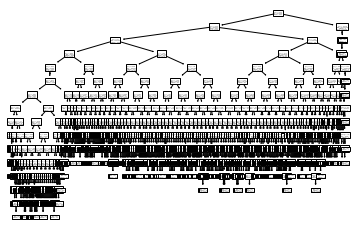

In [ ]:
DTR = DTR.fit(data_prepared, label_train)
tree.plot_tree(DTR) 
plt.show()

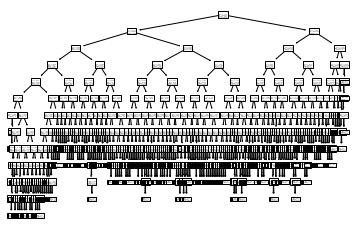

In [ ]:
DTR = DTR.fit(test_prepared, label_test)
tree.plot_tree(DTR) 
plt.show()

Business Insights

In [ ]:
df = pd.DataFrame( columns=['prediction','label'] )
df['prediction']=pd.Series(final_predictions)
df['label']=label_test.reset_index()['Total quantity']
df

,prediction,label
0,6.0,6.0
1,2.0,2.0
2,2.0,2.0
3,1.0,1.0
4,2.0,2.0
...,...,...
16178,4.0,4.0
16179,20.0,20.0
16180,2.0,2.0
16181,1.0,1.0


In [ ]:
Ds=pd.DataFrame(columns=['P','L','D'] )
i=0
for index,row in df.iterrows():
    diff= round(row['prediction'],0)-row['label']
    if not diff==0:
        i+=1
        Ds=Ds.append({'P': row['prediction'],'L': row['label'],'D':diff },ignore_index=True )
print(i)

157


In [ ]:
Ds.describe()

,P,L,D
count,157.000000,157.000000,157.000000
mean,652.312102,650.080573,2.231529
std,564.877351,549.752447,30.631841
min,-275.000000,-271.000000,-36.000000
25%,329.000000,330.000000,-2.000000
50%,536.000000,540.000000,-1.000000
75%,846.000000,852.000000,1.000000
max,4114.000000,3744.000000,370.000000


## Random Forest

In [ ]:
start = time.time()

forest = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)
forest.fit(data_prepared, label_train)

t=(time.time() - start)/60
print( 'Time in minutes:%5.2f'%t)

Time in minutes: 3.43


In [ ]:
predictions = forest.predict(data_prepared)

forest_mse = mean_squared_error(label_train, predictions)
forest_rmse = np.sqrt(forest_mse)
print('RMSE %5.4f'%forest_rmse)

score = forest.score(data_prepared,label_train)
print(' r^2 score %8.3f \n' % score)

RMSE 45.2955
 r^2 score    0.937 



In [ ]:
final_predictions = forest.predict(test_prepared)

final_mse = mean_squared_error(label_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print('RMSE %5.4f'%final_rmse)

RMSE 2.7726


In [ ]:
score = forest.score(test_prepared,label_test)
print(' r^2 score %8.3f \n' % score)

 r^2 score    0.999 



Business Insights

In [ ]:
df = pd.DataFrame( columns=['prediction','label'] )
df['prediction']=pd.Series(final_predictions)
df['label']=label_test.reset_index()['Total quantity']
df

,prediction,label
0,6.001679,6.0
1,2.050186,2.0
2,2.050186,2.0
3,1.148348,1.0
4,2.050186,2.0
...,...,...
16178,4.224698,4.0
16179,19.976928,20.0
16180,2.050186,2.0
16181,1.148348,1.0


In [ ]:
Ds=pd.DataFrame(columns=['P','L','D'] )
i=0
for index,row in df.iterrows():
    diff= round(row['prediction'],0)-row['label']
    if not diff==0:
        i+=1
        Ds=Ds.append({'P': row['prediction'],'L': row['label'],'D':diff },ignore_index=True )
print(i)

1601


In [ ]:
Ds.describe()

,P,L,D
count,1601.000000,1601.000000,1601.000000
mean,75.960547,76.008526,-0.340194
std,280.629234,277.645428,8.829065
min,-275.341667,-271.000000,-30.000000
25%,2.437442,3.000000,-1.000000
50%,2.437442,3.000000,-1.000000
75%,2.437442,3.000000,-1.000000
max,4082.100000,3744.000000,338.000000
